In [1]:
# %matplotlib widget
# %matplotlib tk
import godot

import numpy as np
from godot.core import tempo, util
import matplotlib.pyplot as plt
import pickle


# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

import os
os.makedirs('./output/',exist_ok = True)

# create the universe
uni_config = godot.cosmos.util.load_yaml('universe2.yml')
uni = godot.cosmos.Universe(uni_config)

In [2]:
t = tempo.Epoch('2026-03-14T07:10:00 TDB')
moon = uni.frames.vector3('Moon','Moon','ICRF', t)
sun = uni.frames.vector3('Moon','Sun','ICRF', t)
earth = uni.frames.vector3('Moon','Earth', 'ICRF', t)
sc = uni.frames.vector3('Moon','SC', 'ICRF', t)
print(sc.shape)

(3,)


In [3]:
from mani import GodotHandler
from godot.core import tempo
uni_file = './universe2.yml'
ep1 = tempo.Epoch('2028-01-01T00:00:00 TDB')
ep2 = tempo.Epoch('2029-01-01T00:00:00 TDB')
godotHandler = GodotHandler(ep1, ep2, 1.0, './universe2.yml')
res = godotHandler.calculate_visibility()

Initializing calculate visibility
Initializing Halo Orbit
Time (TU),X (LU),Y (LU),Z (LU),VX (LU/TU),VY (LU/TU),VZ (LU/TU)

Creating chunks
Evaluating chunks


100%|██████████| 31623/31623 [00:00<00:00, 4129661.73it/s]


Moving chunks to StateEvaluator


In [4]:
try:
    res
except NameError:
    print("Res not defined")
    with open('one_year.pickle', 'rb') as f:
        res = pickle.load(f)
else:
    print("Continues working with loaded res")
    with open('one_year.pickle', 'wb') as f:
        pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

Continues working with loaded res


In [5]:
from mani.utils import get_view_times_span, get_view_time_lengths
from mani import SEEnum
event_grid = res['time']
elev_lim = 10
pos_flags = [SEEnum.SUN_ON_SPACECRAFT, SEEnum.CLEAR_MOON_NN]
pos_flags = [SEEnum.CLEAR_MOON_NN]
neg_flags = [SEEnum.SUN_ON_MOON]
condition = res.above_elev('NN11',elev_lim) & res.has(pos_flags) & res.has_not(neg_flags)
NN_time_spans = get_view_times_span(event_grid, condition)

pos_flags = [SEEnum.SUN_ON_SPACECRAFT, SEEnum.CLEAR_MOON_CB]
pos_flags = [SEEnum.CLEAR_MOON_CB]
neg_flags = [SEEnum.SUN_ON_MOON]
condition = res.above_elev('CB11',elev_lim) & res.has(pos_flags) & res.has_not(neg_flags)
CB_time_spans = get_view_times_span(event_grid, condition)

pos_flags = [SEEnum.SUN_ON_SPACECRAFT, SEEnum.CLEAR_MOON_MG]
pos_flags = [SEEnum.CLEAR_MOON_MG]
neg_flags = [SEEnum.SUN_ON_MOON]
condition = res.above_elev('MG11',elev_lim) & res.has(pos_flags) & res.has_not(neg_flags)
MG_time_spans = get_view_times_span(event_grid, condition)

NN_arr =  get_view_time_lengths(NN_time_spans)
CB_arr =  get_view_time_lengths(CB_time_spans)
MG_arr =  get_view_time_lengths(MG_time_spans)

In [6]:
print(NN_time_spans.shape)
print(NN_arr.shape)

(2371, 2)
(2371,)


In [7]:
from mani.utils import get_date_string, convert_to_datetime

%matplotlib inline
%matplotlib widget
def plot_distributions(arrs, time_spans, labels, filename):
    if type(arrs) == np.ndarray:
        arrs = arrs[np.newaxis, :]
    
    arr_len = len(arrs)

    fig = plt.figure(figsize = (18,5))
    ax0, ax1, ax2 = fig.subplots(1,3)

    for i in range(arr_len):
        arr = arrs[i]
        if arr_len == 1:
            name = labels
            arr_times = [time.mjd()-time_spans[0,0].mjd() for time in time_spans[:,0]]
        else: 
            name = labels[i]
            arr_times = [time.mjd()-time_spans[i][0,0].mjd() for time in time_spans[i][:,0]]
        vals, bins = np.histogram(arr, bins=1000, weights=np.ones(len(arr)) / len(arr))
        ax0.plot(bins[:-1], np.cumsum(vals), label = name)
        ax1.hist(arr, bins = 100, weights=np.ones(len(arr)) / len(arr), label = name)
        ax2.scatter(arr_times, arr, label= name, s=3)

    ax0.grid()
    ax0.set_xlabel('Duration [s]')
    ax0.set_ylabel('Cumulative Distribution Function')
    ax0.legend()
    ax0.set_title('CDF of Visible Durations')

    ax1.grid()
    ax1.set_xlabel('Duration [s]')
    ax1.set_ylabel('Normalized Distribution')
    ax1.set_title('Histogram of Visbile Durations')
    ax1.legend()

    ax2.grid()
    ax2.set_xlabel('Starting time of visibility period [day]')
    ax2.set_ylabel('Duration [s]')
    ax2.set_title('Duration of visibility')
    ax2.legend()

    all_times = []
    if arr_len == 1:
        all_times.extend(time_spans)
    else:
        [all_times.extend(time_span) for time_span in time_spans]
    start_t = get_date_string(np.min(all_times))
    end_t = get_date_string(np.max(all_times))

    fig.suptitle(f'Visibility duration evaluated from {start_t} to {end_t}')

    fig.savefig('./output/'+filename+'.png', bbox_inches='tight')

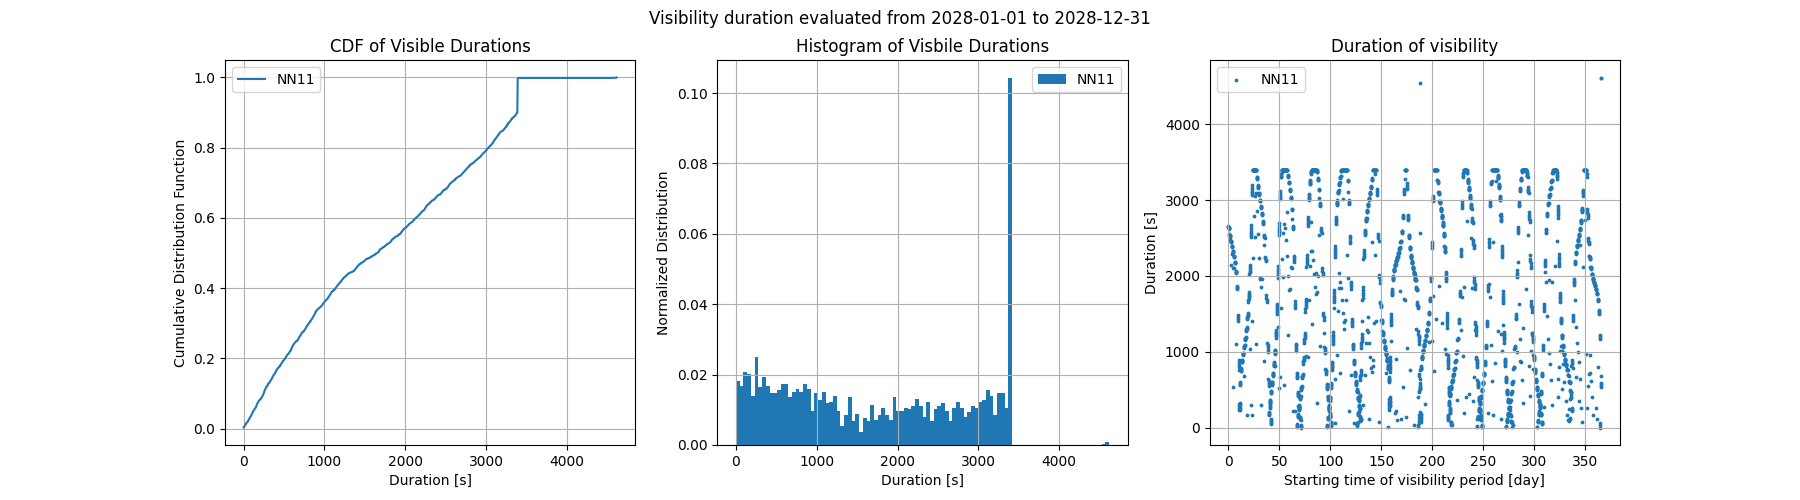

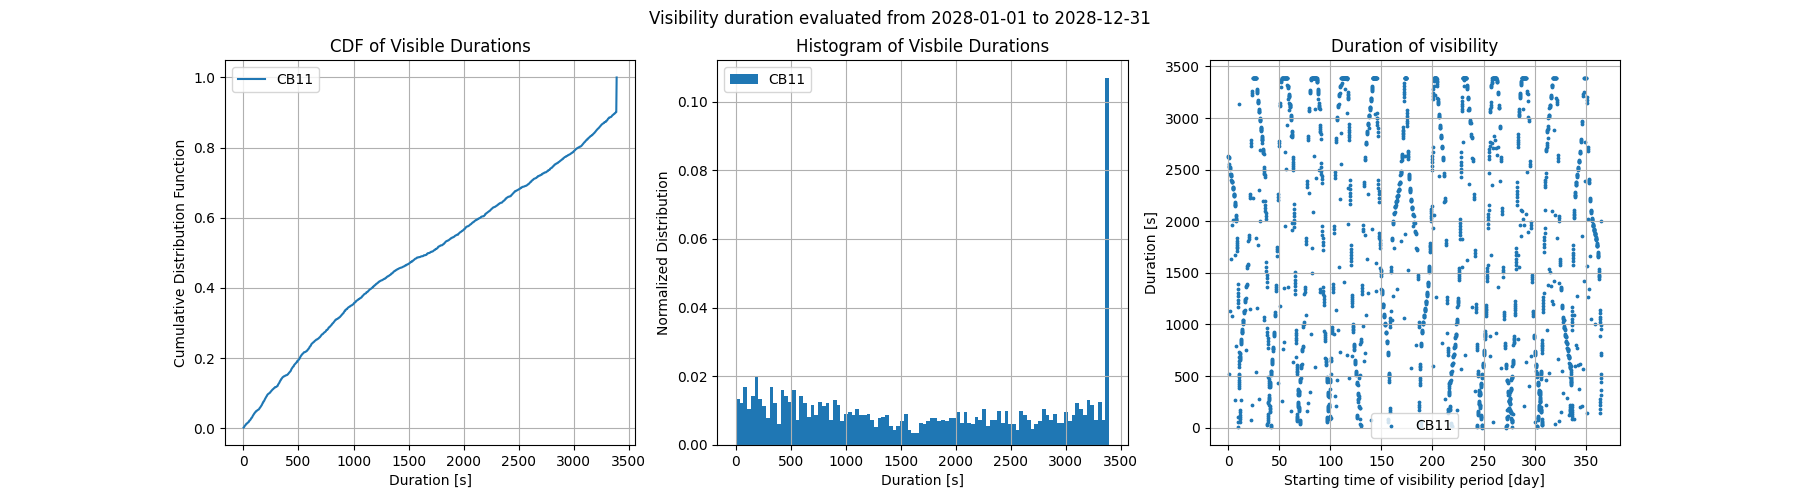

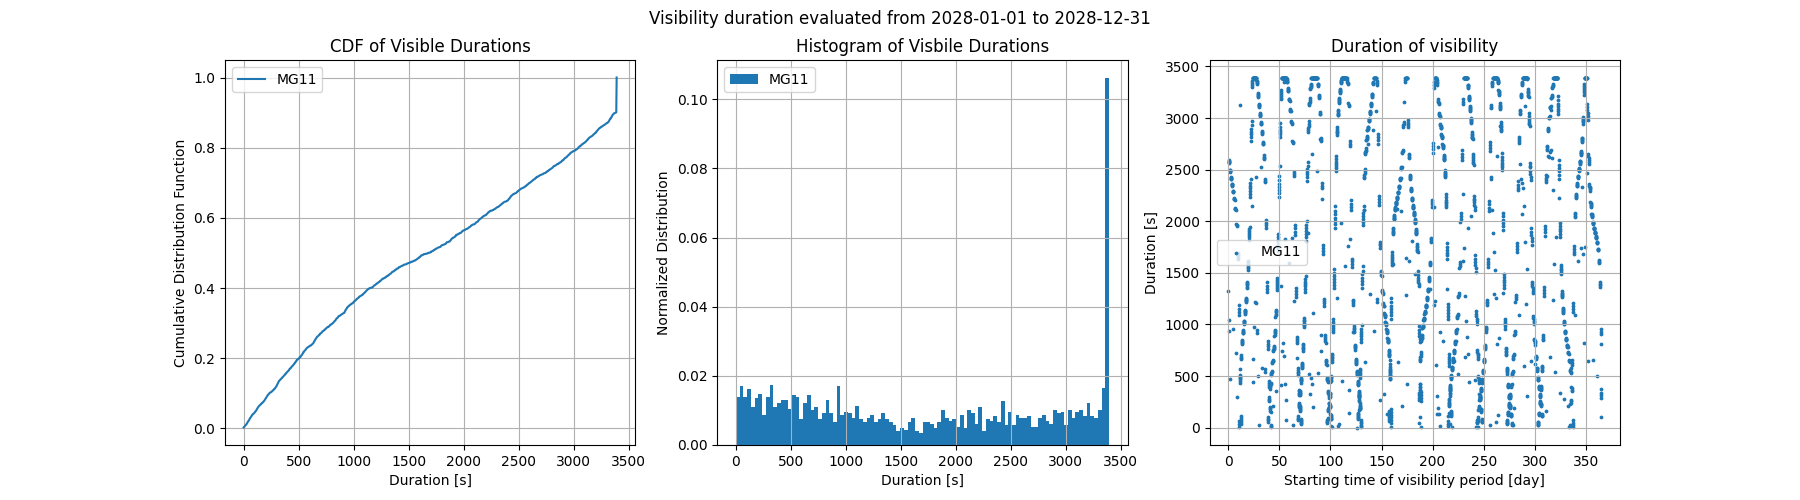

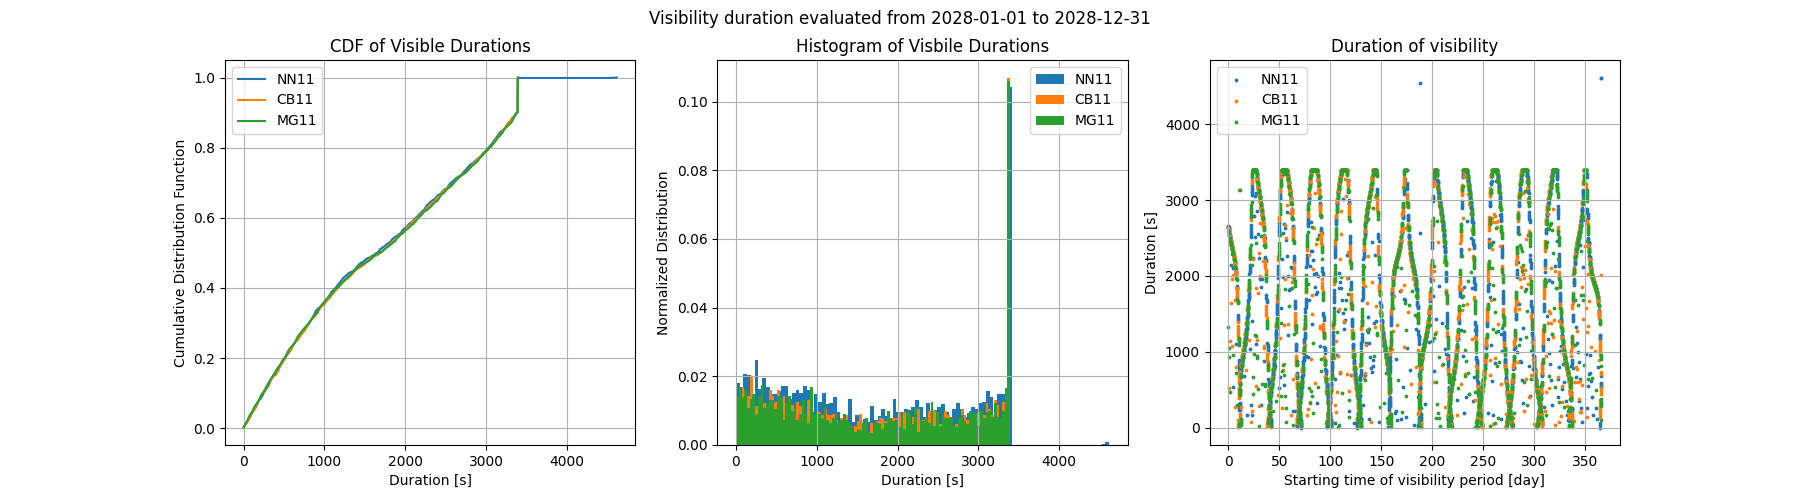

In [8]:
plot_distributions(NN_arr, NN_time_spans, 'NN11', 'NN_only')
plot_distributions(CB_arr, CB_time_spans, 'CB11', 'CB_only')
plot_distributions(MG_arr, MG_time_spans, 'MG11', 'MG_only')
plot_distributions([NN_arr, CB_arr, MG_arr],
                   [NN_time_spans, CB_time_spans, MG_time_spans],
                   ['NN11','CB11','MG11'],
                   'common')

HP mode 2028-01-01T01:03:06.000000 TDB to 2028-01-01T01:25:10.000000 TDB, duration 1324.0 secs
HP mode 2028-01-01T02:56:26.000000 TDB to 2028-01-01T03:40:41.000000 TDB, duration 2655.0 secs
HP mode 2028-01-01T04:49:38.000000 TDB to 2028-01-01T05:33:45.000000 TDB, duration 2647.0 secs
HP mode 2028-01-01T06:42:49.000000 TDB to 2028-01-01T07:26:49.000000 TDB, duration 2640.0 secs
HP mode 2028-01-01T08:36:01.000000 TDB to 2028-01-01T09:19:54.000000 TDB, duration 2633.0 secs
HP mode 2028-01-01T10:29:13.000000 TDB to 2028-01-01T11:12:58.000000 TDB, duration 2625.0 secs
HP mode 2028-01-01T12:22:10.000000 TDB to 2028-01-01T13:06:02.000000 TDB, duration 2632.0 secs
HP mode 2028-01-01T14:15:21.000000 TDB to 2028-01-01T14:59:06.000000 TDB, duration 2625.0 secs
HP mode 2028-01-01T16:08:32.000000 TDB to 2028-01-01T16:52:10.000000 TDB, duration 2618.0 secs
HP mode 2028-01-01T18:01:43.000000 TDB to 2028-01-01T18:45:14.000000 TDB, duration 2611.0 secs
HP mode 2028-01-01T19:54:55.000000 TDB to 2028-01-

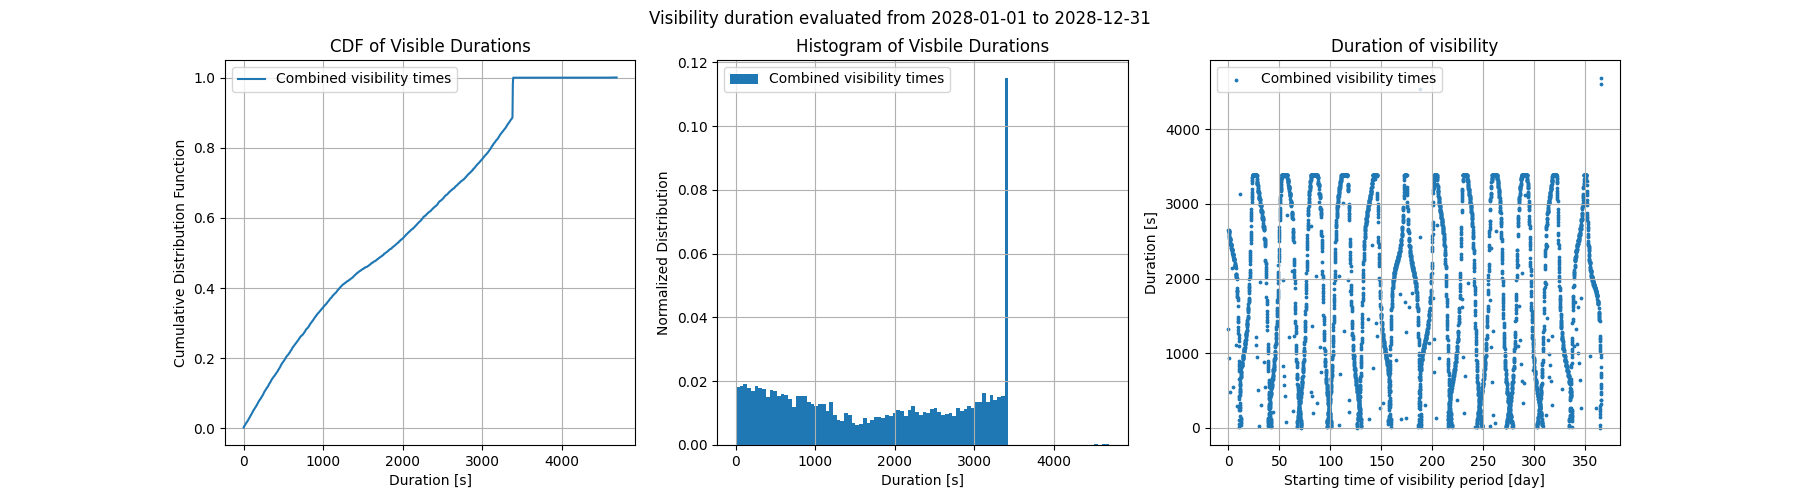

In [9]:
elev_lim = 10
los_NN = res.above_elev('NN11', elev_lim) & res.has([SEEnum.CLEAR_MOON_NN])
los_CB = res.above_elev('CB11', elev_lim) & res.has([SEEnum.CLEAR_MOON_CB])
los_MG = res.above_elev('MG11', elev_lim) & res.has([SEEnum.CLEAR_MOON_MG])
condition = (los_NN | los_CB | los_MG) & res.has_not([SEEnum.SUN_ON_MOON])
view_time_span = get_view_times_span(res['time'], condition)
visibility_length =  get_view_time_lengths(view_time_span)

plot_distributions(visibility_length, view_time_span, 'Combined visibility times', 'combed_vis_time')

for interval in view_time_span:
    start = interval[0]
    end = interval[1]
    print( f"HP mode {start} to {end}, duration {end - start} secs" )
print(np.mean(view_time_span[:,1]-view_time_span[:,0]) / 60 /113)
print(np.mean(view_time_span[:,1]-view_time_span[:,0]))

/home/es820/miniconda3/envs/godot/lib/python3.10/site-packages/ipympl/backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


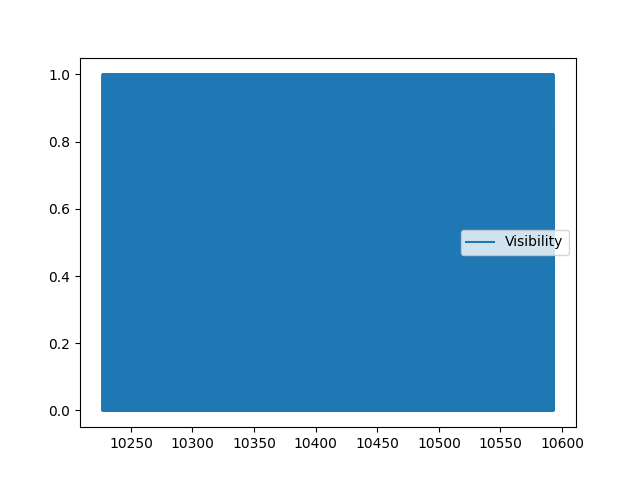

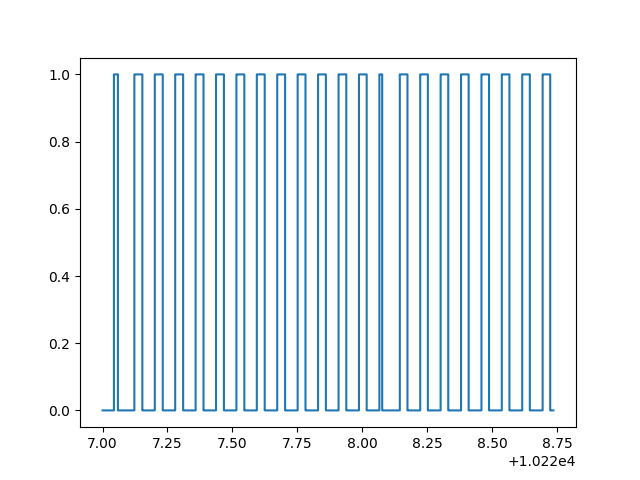

In [10]:
plt.figure()
n  = 1500000
span = [n,n+100000]
event_grid = res['time']
times = [time.mjd() for time in event_grid]
plt.step(times, condition.to_list(), label='Visibility')
plt.legend()
plt.show()

plt.figure()
n  = 0
span = [n,n+150000]
times = [time.mjd() for time in event_grid[span[0]:span[1]]]
plt.step(times, condition.to_list()[span[0]:span[1]], label='Visibility')
plt.show()
del event_grid, times


# Evaluate times where 

/tmp/ipykernel_825956/170174277.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('./output/'+filename+'.png', bbox_inches='tight')


0.051204154600313856
347.16416819012795


/home/es820/miniconda3/envs/godot/lib/python3.10/site-packages/ipympl/backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


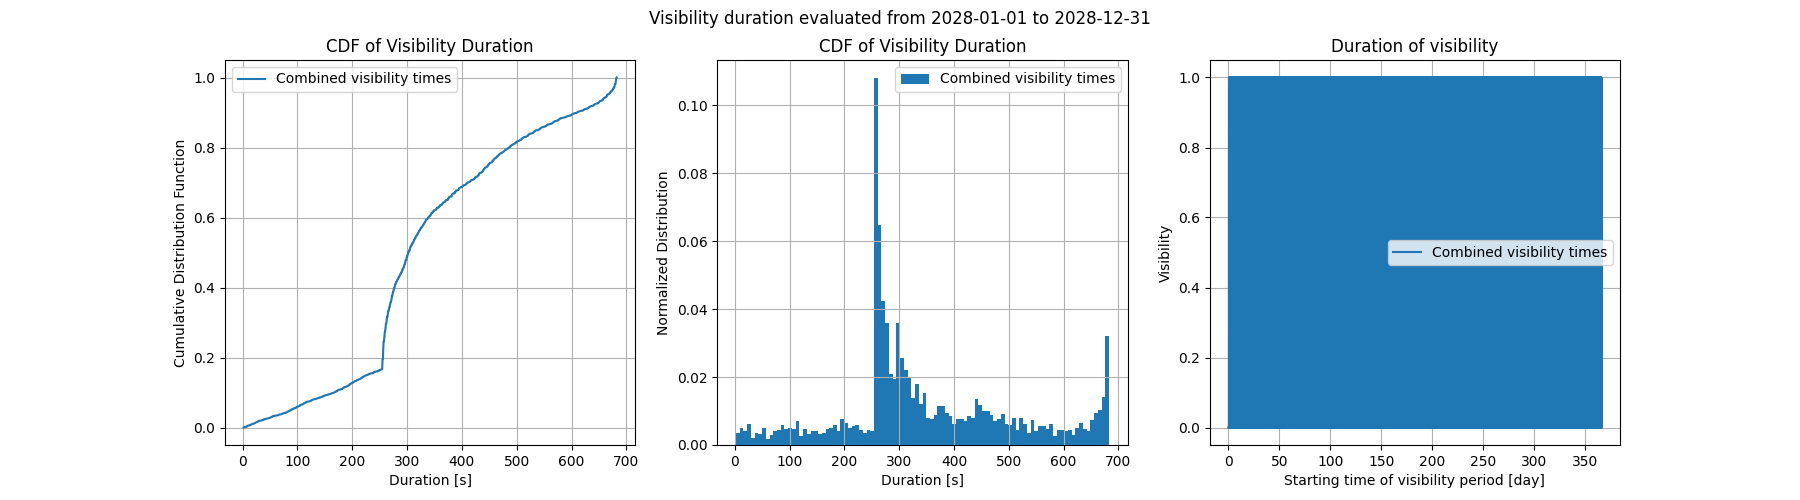

In [12]:
elev_lim = 10
los_CB = res.above_elev('CB11',elev_lim) & res.has([SEEnum.CLEAR_MOON_CB])
condition = (res.has([SEEnum.SUN_ON_SPACECRAFT]) & res.has_not([SEEnum.SUN_ON_MOON]) & los_CB)

rare_sun_spans = get_view_times_span(res['time'], condition)
rare_sun_times =  get_view_time_lengths(rare_sun_spans)

def plot_cdf(ax, bins,vals, name):
    ax.plot(bins[:-1], np.cumsum(vals), label = name)
    ax.grid()
    ax.set_xlabel('Duration [s]')
    ax.set_ylabel('Cumulative Distribution Function')
    ax.legend()
    ax.set_title('CDF of Visibility Duration')

def plot_hist(ax, arr, name):
    ax.hist(arr, bins = 100, weights=np.ones(len(arr)) / len(arr), label = name)
    ax.grid()
    ax.set_xlabel('Duration [s]')
    ax.set_ylabel('Normalized Distribution')
    ax.set_title('CDF of Visibility Duration')
    ax.legend()

def plot_times(ax, grid, condition, name):
    times = [time.mjd()-grid[0].mjd() for time in grid]
    ax.plot(times, condition, label= name)
    ax.grid()
    ax.set_xlabel('Starting time of visibility period [day]')
    ax.set_ylabel('Visibility')
    ax.set_title('Duration of visibility')
    ax.legend()


%matplotlib widget
def plot_distributions_2(arr, time_spans, grid, condition, labels, filename):

    fig = plt.figure(figsize = (18,5))
    ax0, ax1, ax2 = fig.subplots(1,3)

    name = labels
    vals, bins = np.histogram(arr, bins=1000, weights=np.ones(len(arr)) / len(arr))
    plot_cdf(ax0, bins, vals, name)

    plot_hist(ax1, arr, name)

    plot_times(ax2, grid, condition, name)

    all_times = time_spans
    start_t = get_date_string(np.min(all_times))
    end_t = get_date_string(np.max(all_times))

    fig.suptitle(f'Visibility duration evaluated from {start_t} to {end_t}')

    fig.savefig('./output/'+filename+'.png', bbox_inches='tight')

event_grid = res['time']
plot_distributions_2(rare_sun_times, rare_sun_spans, event_grid, condition, 'Combined visibility times', 'sun_times')
del event_grid
for interval in rare_sun_spans:
    start = interval[0]
    end = interval[1]
    #print( f"HP mode {start} to {end}, duration {end - start} secs" )
print(np.mean(rare_sun_spans[:,1]-rare_sun_spans[:,0]) / 60 /113)
print(np.mean(rare_sun_spans[:,1]-rare_sun_spans[:,0]))

In [13]:
elev_lim = 10
condition = res.above_elev('CB11', elev_lim) & res.has([SEEnum.CLEAR_MOON_CB])

def get_elev_in_los(times, elevations, conditions):
    timestamps = []
    elevationsstamps = []
    for i, t in enumerate(times):
        if conditions[i]:
            timestamps.append(convert_to_datetime(t))
            elevationsstamps.append(elevations[i])
    return timestamps, elevationsstamps

timestamps, elevations = get_elev_in_los(res['time'], res['CB11'], condition)

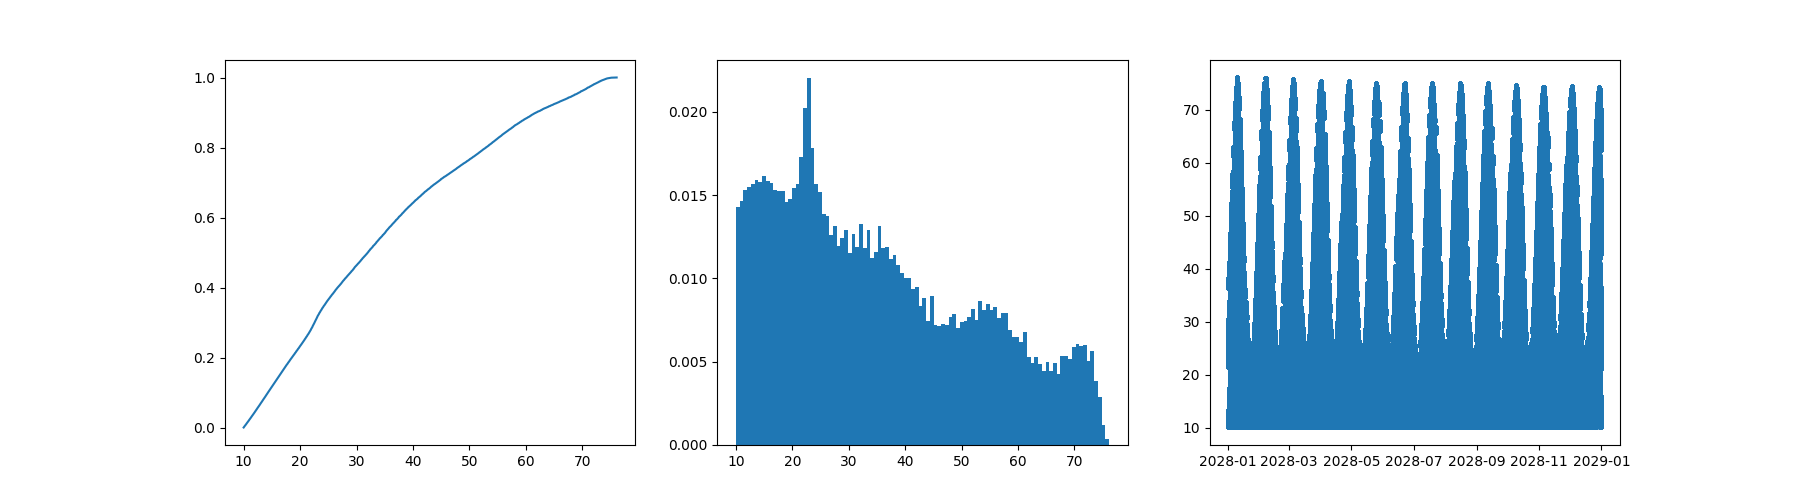

In [14]:
plt.subplots(1,3, figsize = (18,5))
vals, bins = np.histogram(elevations, bins=1000, weights=np.ones(len(elevations)) / len(elevations))
plt.subplot(1,3,1)
plt.plot(bins[:-1], np.cumsum(vals))
plt.subplot(1,3,2)
plt.hist(elevations, bins = 100, weights=np.ones(len(elevations)) / len(elevations))
plt.subplot(1,3,3)
plt.scatter(timestamps, elevations, s=3)
plt.show()

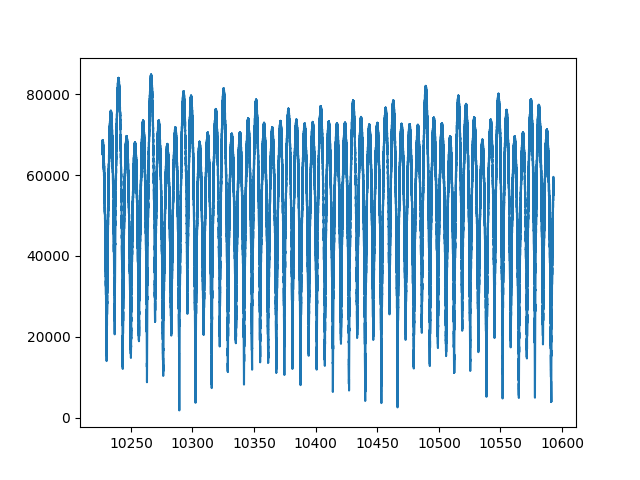

1807
84921


In [15]:
# from mani import SEEnum

# elev_lim = 10
# pos_flags = [SEEnum.LOS_GW]
# condition = res.has(pos_flags)
# los_gw = godotHandler.get_view_times_span(condition)
plt.figure()
times = [timestamp.mjd() for timestamp in res['time']]
plt.plot(times, res.df['gw_dist'])
plt.show()
print(np.min(res.df['gw_dist']))
print(np.max(res.df['gw_dist']))

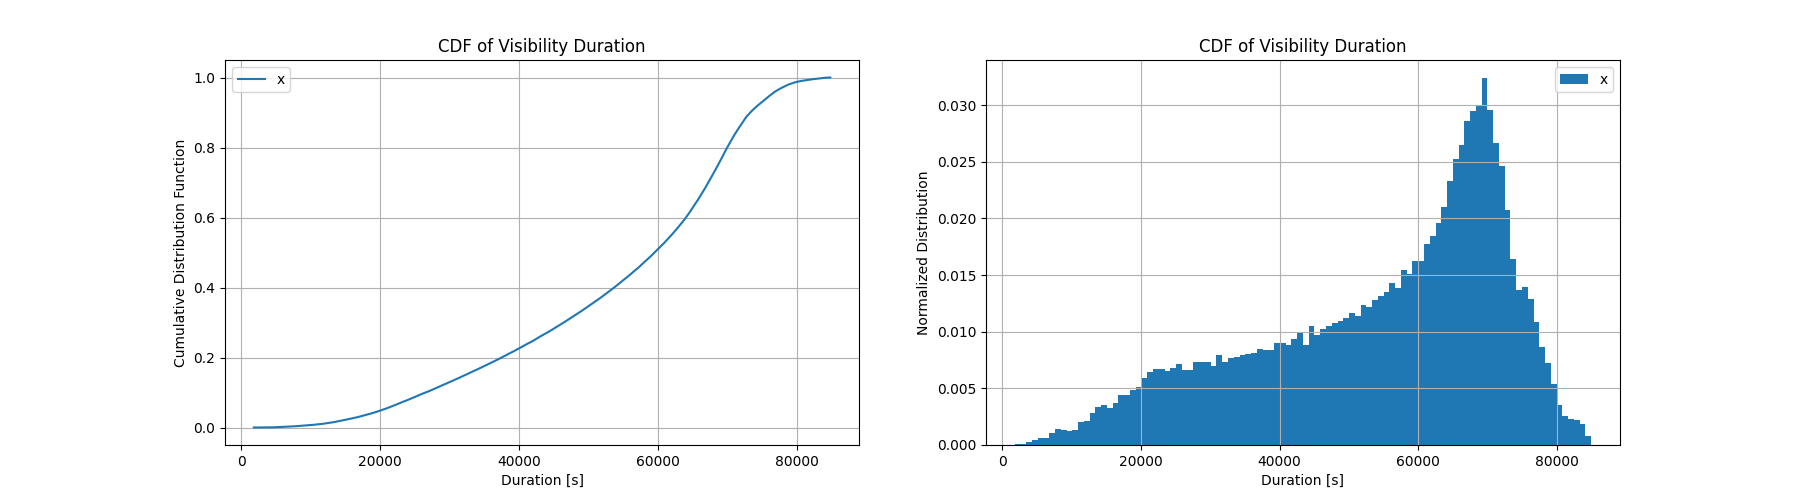

In [ ]:
fig = plt.figure(figsize = (18,5))
ax0, ax1 = fig.subplots(1,2)
arr = res.df['gw_dist']
name = 'x'
vals, bins = np.histogram(arr, bins=1000, weights=np.ones(len(arr)) / len(arr))
plot_cdf(ax0, bins, vals, name)

plot_hist(ax1, arr, name)

# plot_times(ax2, res['time'], condition, name)

plt.show()

In [ ]:
elev_lim = 10
gw = res.has([SEEnum.LOS_GW])
view_time_span = get_view_times_span(res['time'], condition)
visibility_length =  get_view_time_lengths(view_time_span)

plot_distributions(visibility_length, view_time_span, 'Combined visibility times', 'combed_vis_time')